# Parameters Sweep Analysis

In [1]:
import evol_dynamics

In [2]:
import pandas as pd
import dask.dataframe as dd

import numpy as np
import tqdm
import itertools

In [3]:
import matplotlib.pyplot as plt
import matplotlib

cmaps = [matplotlib.cm.get_cmap("Blues"), matplotlib.cm.get_cmap("Reds")]

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import glob

**Clean data**

In [118]:
columns = ["y", "p", "q", "average cooperation rate", "average score", "t"]

In [117]:
csv_files = glob.glob('matlab/data/expected/*csv')

In [128]:
for file in tqdm.tqdm_notebook(csv_files):    
    df = pd.read_csv(file, header=None)
    df = df.drop_duplicates()
    df.columns = columns
    
    frequencies = []
    previous = 0
    for value in df['t'][1:]:
        frequencies.append(value - previous)
        previous = value
    frequencies.append(10 ** 7 - previous)
    
    df['frequencies'] = frequencies
    
    df.to_csv(f"matlab/data/clean/{file[21:]}")

/Users/glynatsi/opt/anaconda3/envs/stochastic-payoffs/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


**Generate individual plots - for each trial**

In [92]:
columns = ["y", "p", "q", "average cooperation rate", "average score", "t"]

In [111]:
df = pd.read_csv('matlab/data/expected/S_0.4_T_3_stochastic_0.csv', header=None)
df = df.drop_duplicates()

In [112]:
df.columns = columns

In [113]:
df.head()

,y,p,q,average cooperation rate,average score,t
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.0
1,0.86307,0.67717,0.06422,0.16772,0.50088,61.0
2,0.44164,0.37995,0.42436,0.40635,0.98530,64.0
3,0.48827,0.41903,0.22956,0.28347,0.77085,91.0
4,0.89453,0.87697,0.08722,0.41712,0.99918,1236.0


In [114]:
frequencies = []
previous = 0
for value in df['t'][1:]:
    frequencies.append(value - previous)
    previous = value
frequencies.append(10 ** 7 - previous)

In [115]:
df['frequencies'] = frequencies

In [116]:
sum(df['average cooperation rate'] * (df['frequencies'] / 10 ** 7))

0.3491693427090193

In [88]:
ps = []
qs = []
for p, q, v in zip(df["p"], df["q"], df["frequencies"]):
    for _ in range(int(v)):
        ps.append(p)
        qs.append(q)

In [89]:
heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=15)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


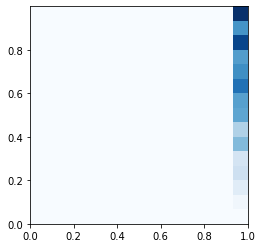

In [90]:
plt.imshow(heatmap.T, extent=extent, cmap=cmaps[0], origin="lower");

In [11]:
df[["p", "q"]].tail()

,p,q
99995,0.0,0.0
99996,0.0,0.0
99997,0.0,0.0
99998,0.0,0.0
99999,0.0,0.0


In [13]:
df[df["t"] < 10000]

,y,p,q,average cooperation rate,average score,t
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0
1,0.530580,0.36426,0.035601,0.05374,-0.027215,587.0
2,0.073797,0.41745,0.949840,0.61948,0.242990,610.0
3,0.874100,0.92095,0.769660,0.90681,0.771610,622.0
4,0.095966,0.99243,0.682740,0.98774,0.969770,822.0
...,...,...,...,...,...,...
99995,0.000000,0.00000,0.000000,0.00000,0.000000,0.0
99996,0.000000,0.00000,0.000000,0.00000,0.000000,0.0
99997,0.000000,0.00000,0.000000,0.00000,0.000000,0.0
99998,0.000000,0.00000,0.000000,0.00000,0.000000,0.0


In [6]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13,
        }

In [7]:
csv_files = glob.glob('matlab/data/expected/*csv')

In [120]:
for file in tqdm.notebook.tqdm(csv_files):
    
    df = dd.read_csv(file,
                 header=None,
                 dtype=np.float64,
                 names=columns)
    
    text_file = open(file.replace("csv", "txt"), "r")
    data = text_file.readlines()
    
    
    mean_cooperation = df['average cooperation rate'].mean()
    mean_score = df['average score'].mean()
    title = data[0].replace('\n', '')
    ps = df['p'].values.compute()
    qs = df['q'].values.compute()
    
    fig, axes = plt.subplots(figsize=(10, 7));

    heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=15)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axes.imshow(heatmap.T, extent=extent, cmap=cmaps[0], origin="lower")

    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    title = data[0].replace("\n", "")
    axes.set_title(title)

    axes.set_xticks(np.linspace(0, 1, 2))
    axes.set_yticks(np.linspace(0, 1, 2))

    axes.text(.2, .9, f'mean cooperation: {round(mean_cooperation.compute(), 3)}', fontdict=font)
    axes.text(.2, .85, f'mean score: {round(mean_score.compute(), 3)}', fontdict=font)


    fig.savefig(f'matlab/images/{title}.pdf')
    plt.close(); 

**Generate plot across axis**

In [129]:
import numbers

In [130]:
Ss = [2, 1.6, 1.2, 0.8, 0.4, 0, -0.4, -0.8, -1.2, -1.6, -2]
Ts = [-1, -0.6, -0.2,  0.2,  0.6,  1,  1.4,  1.8,  2.2,  2.6,  3]

In [131]:
sorted_cvs_files = [f"matlab/data/clean/S_{S}_T_{T}_stochastic_0.csv" for S in Ss for T in Ts]

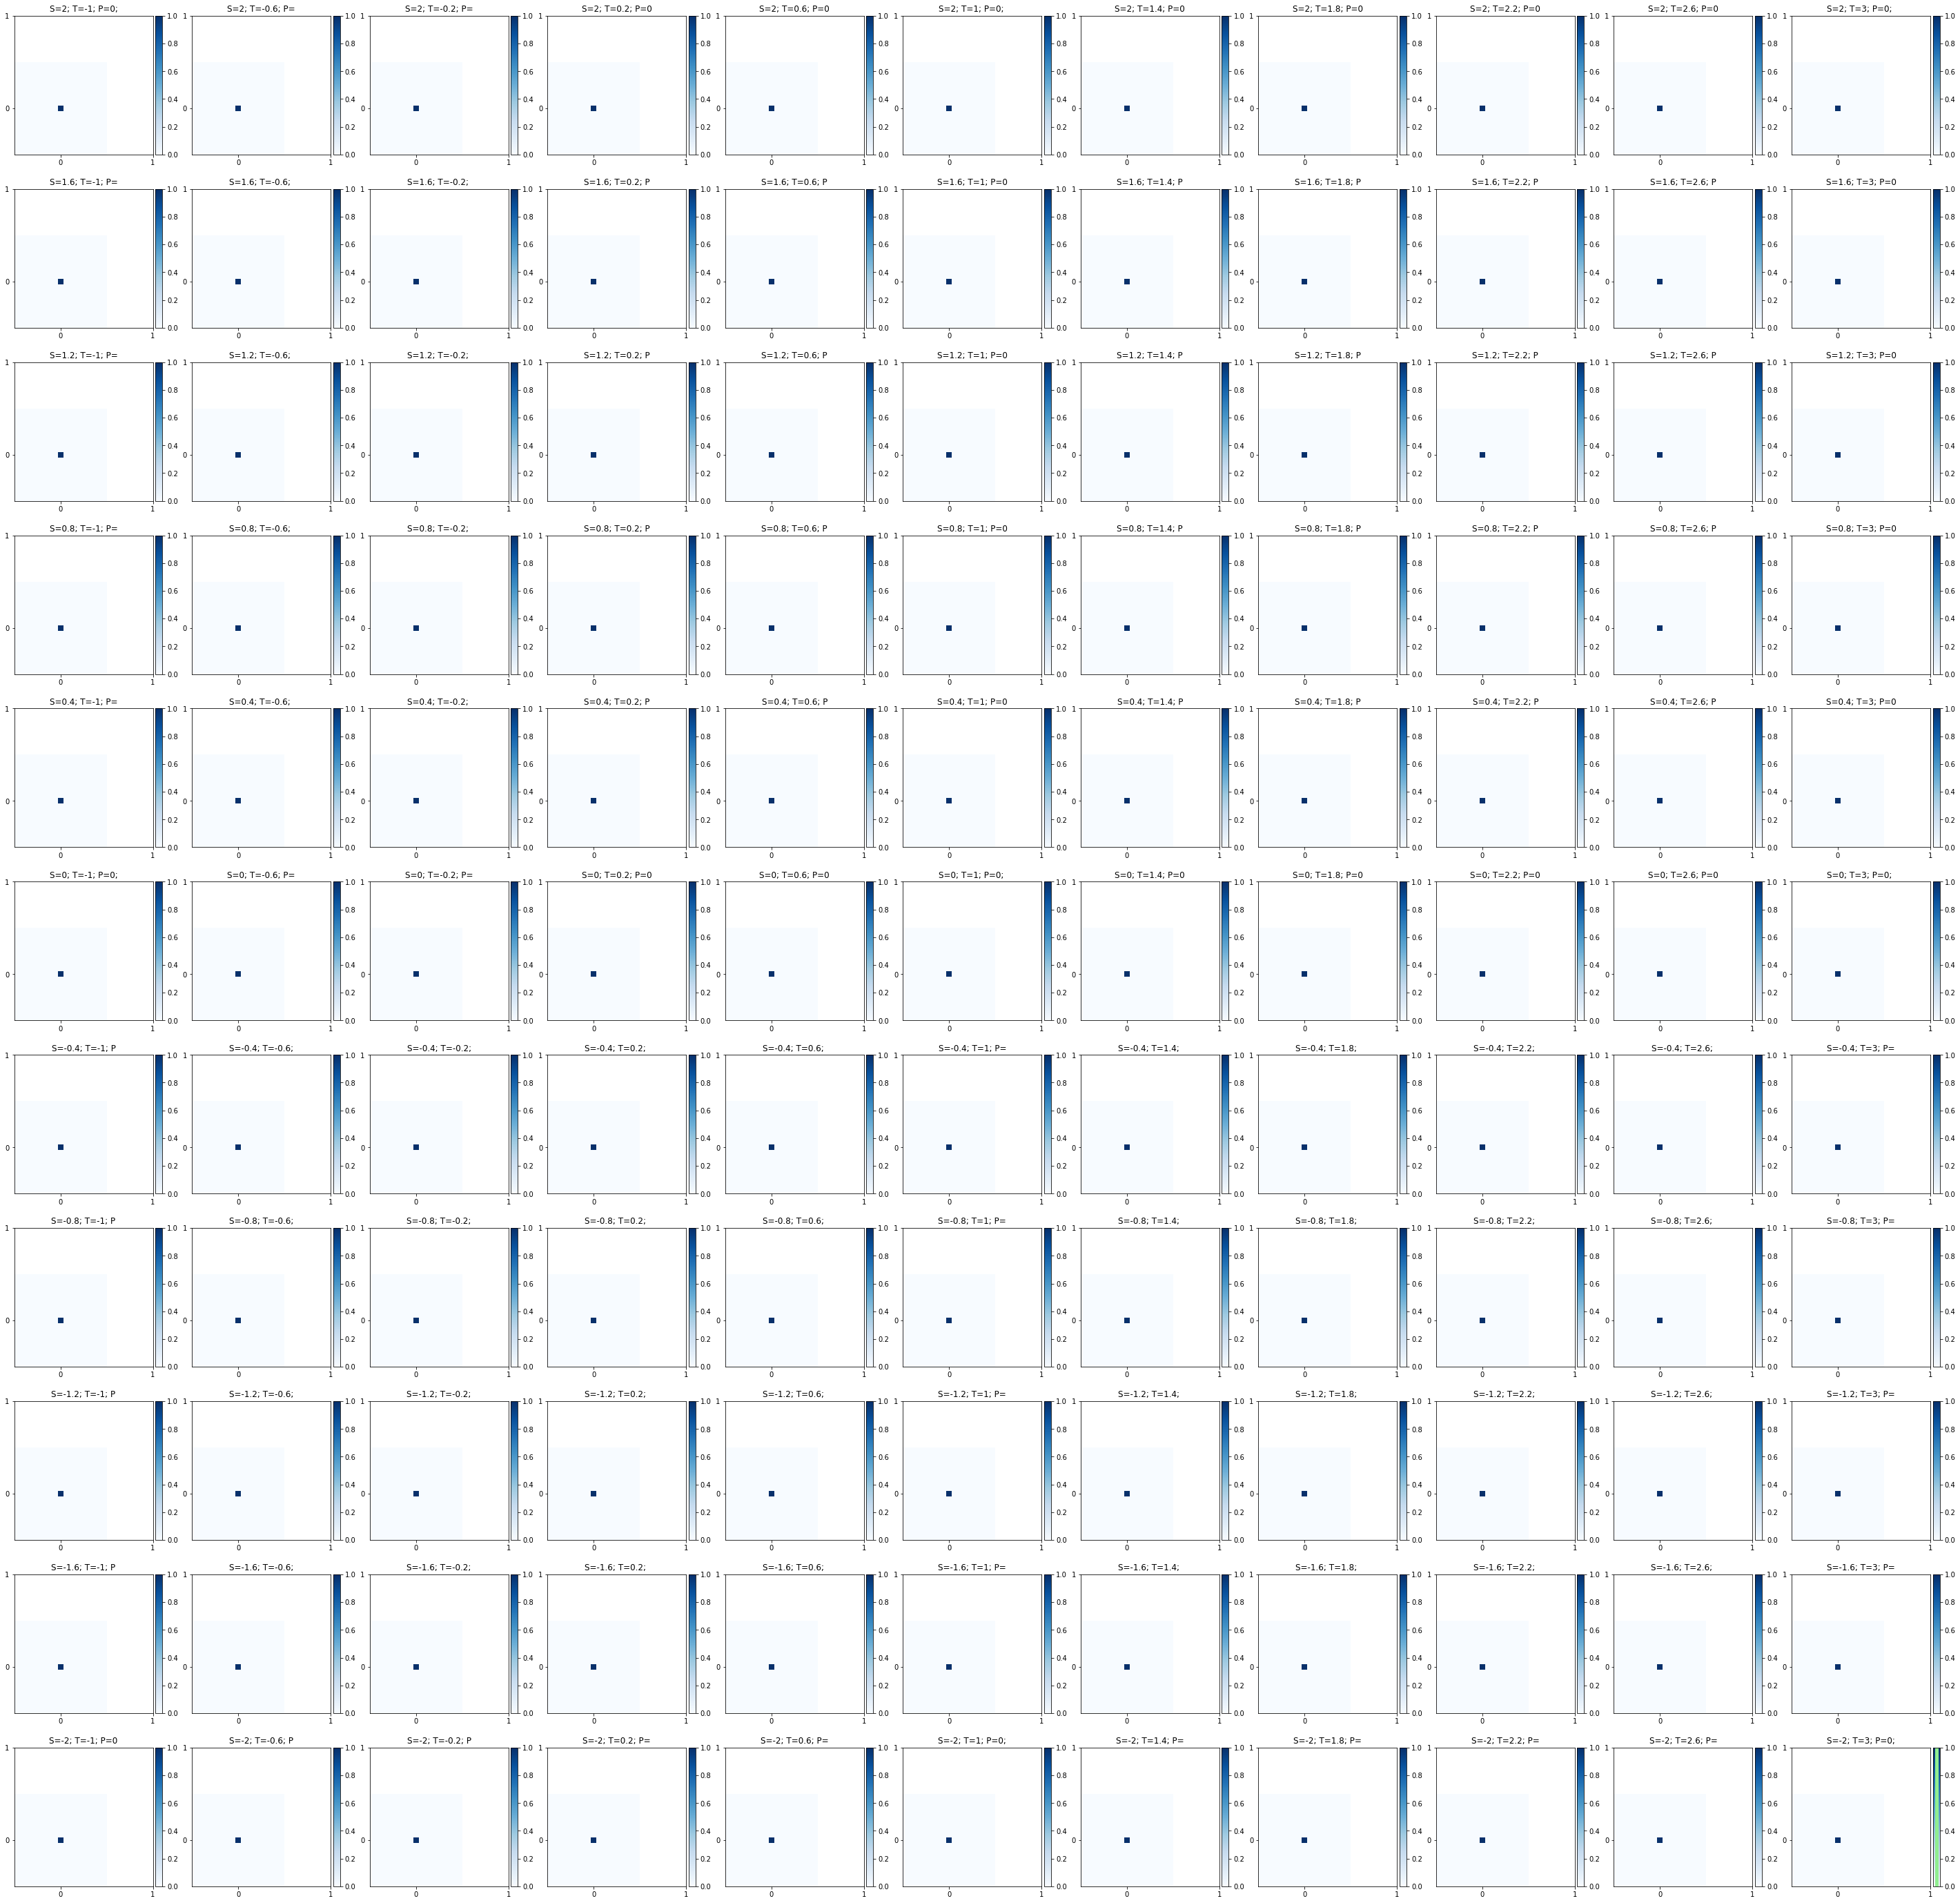

In [16]:
fig, axes = plt.subplots(nrows=11, ncols=11, figsize=(50, 50));

for i, file in enumerate(sorted_cvs_files):
    
    df = dd.read_csv(file,
                 header=None,
                 dtype=np.float64,
                 names=columns)
    
    text_file = open(file.replace("csv", "txt"), "r")
    data = text_file.readlines()
    
    ps = df['p'].values.compute()
    qs = df['q'].values.compute()
    title = data[0][5:20]
    
    index = (int(i / 11), i % 11)
    
    heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=15)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axes[index].imshow(heatmap.T, extent=extent, cmap=cmaps[0], origin="lower")

    divider = make_axes_locatable(axes[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axes[index].set_title(title)

    axes[index].set_xticks(np.linspace(0, 1, 2))
    axes[index].set_yticks(np.linspace(0, 1, 2))
        
fig.savefig("matlab/images/merged_plot.pdf")

In [132]:
cooperation_rates = np.zeros((11, 11))
scores = np.zeros((11, 11))

In [133]:
for i, file in enumerate(sorted_cvs_files):
    x = int(i / 11)
    y = i % 11
    
    df = pd.read_csv(file)
    
    cooperation_rates[int(x), int(y)] = sum(df['average cooperation rate'] * (df['frequencies'] / 10 ** 7))
    scores[x, y] = sum(df['average score'] * (df['frequencies'] / 10 ** 7))

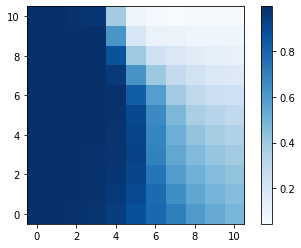

In [134]:
plt.imshow(cooperation_rates, origin="lower", cmap=cmaps[0])

plt.colorbar();

In [22]:
df.tail()

,y,p,q,average cooperation rate,average score,t
215003,0.056409,0.17881,0.020174,0.50755,0.50755,10000000.0
215004,0.056409,0.17881,0.020174,0.97992,0.97992,10000000.0
215005,0.056409,0.17881,0.020174,0.77314,0.77314,10000000.0
215006,0.056409,0.17881,0.020174,0.60703,0.60703,10000000.0
215007,0.056409,0.17881,0.020174,0.93472,0.93472,10000000.0


In [23]:
player = [0.056409, 0.17881, 0.020174]

In [26]:
v = evol_dynamics.expected_distribution_last_round(player, player, 0.999)

In [28]:
v[0] + v[1]

0.02401627019335461

In [21]:
data

['R=1; S=-2; T=3; P=0; N=121; beta=1; nIt=10000000; stochastic=0\n']

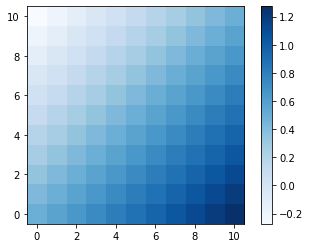

In [152]:
plt.imshow(scores, origin="lower", cmap=cmaps[0])

plt.colorbar();

**Similar for stochastic payoffs**

In [131]:
csv_files = glob.glob('matlab/data/stochastic/*csv')

In [154]:
for file in tqdm.tqdm_notebook(csv_files):
    
    df = dd.read_csv(file,
                 header=None,
                 dtype=np.float64,
                 names=columns)
    
    text_file = open(file.replace("csv", "txt"), "r")
    data = text_file.readlines()
    
    
    mean_cooperation = df['average cooperation rate'].mean()
    mean_score = df['average score'].mean()
    title = data[0].replace('\n', '')
    ps = df['p'].values.compute()
    qs = df['q'].values.compute()
    
    fig, axes = plt.subplots(figsize=(10, 7));

    heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=15)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axes.imshow(heatmap.T, extent=extent, cmap=cmaps[1], origin="lower")

    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    title = data[0].replace("\n", "")
    axes.set_title(title)

    axes.set_xticks(np.linspace(0, 1, 2))
    axes.set_yticks(np.linspace(0, 1, 2))

    axes.text(.2, .9, f'mean cooperation: {round(mean_cooperation.compute(), 3)}', fontdict=font)
    axes.text(.2, .85, f'mean score: {round(mean_score.compute(), 3)}', fontdict=font)


    fig.savefig(f'matlab/images/{title}.pdf')
    plt.close(); 

In [155]:
sorted_cvs_files = [f"matlab/data/stochastic/S_{S}_T_{T}_stochastic_1.csv" for S in Ss for T in Ts]

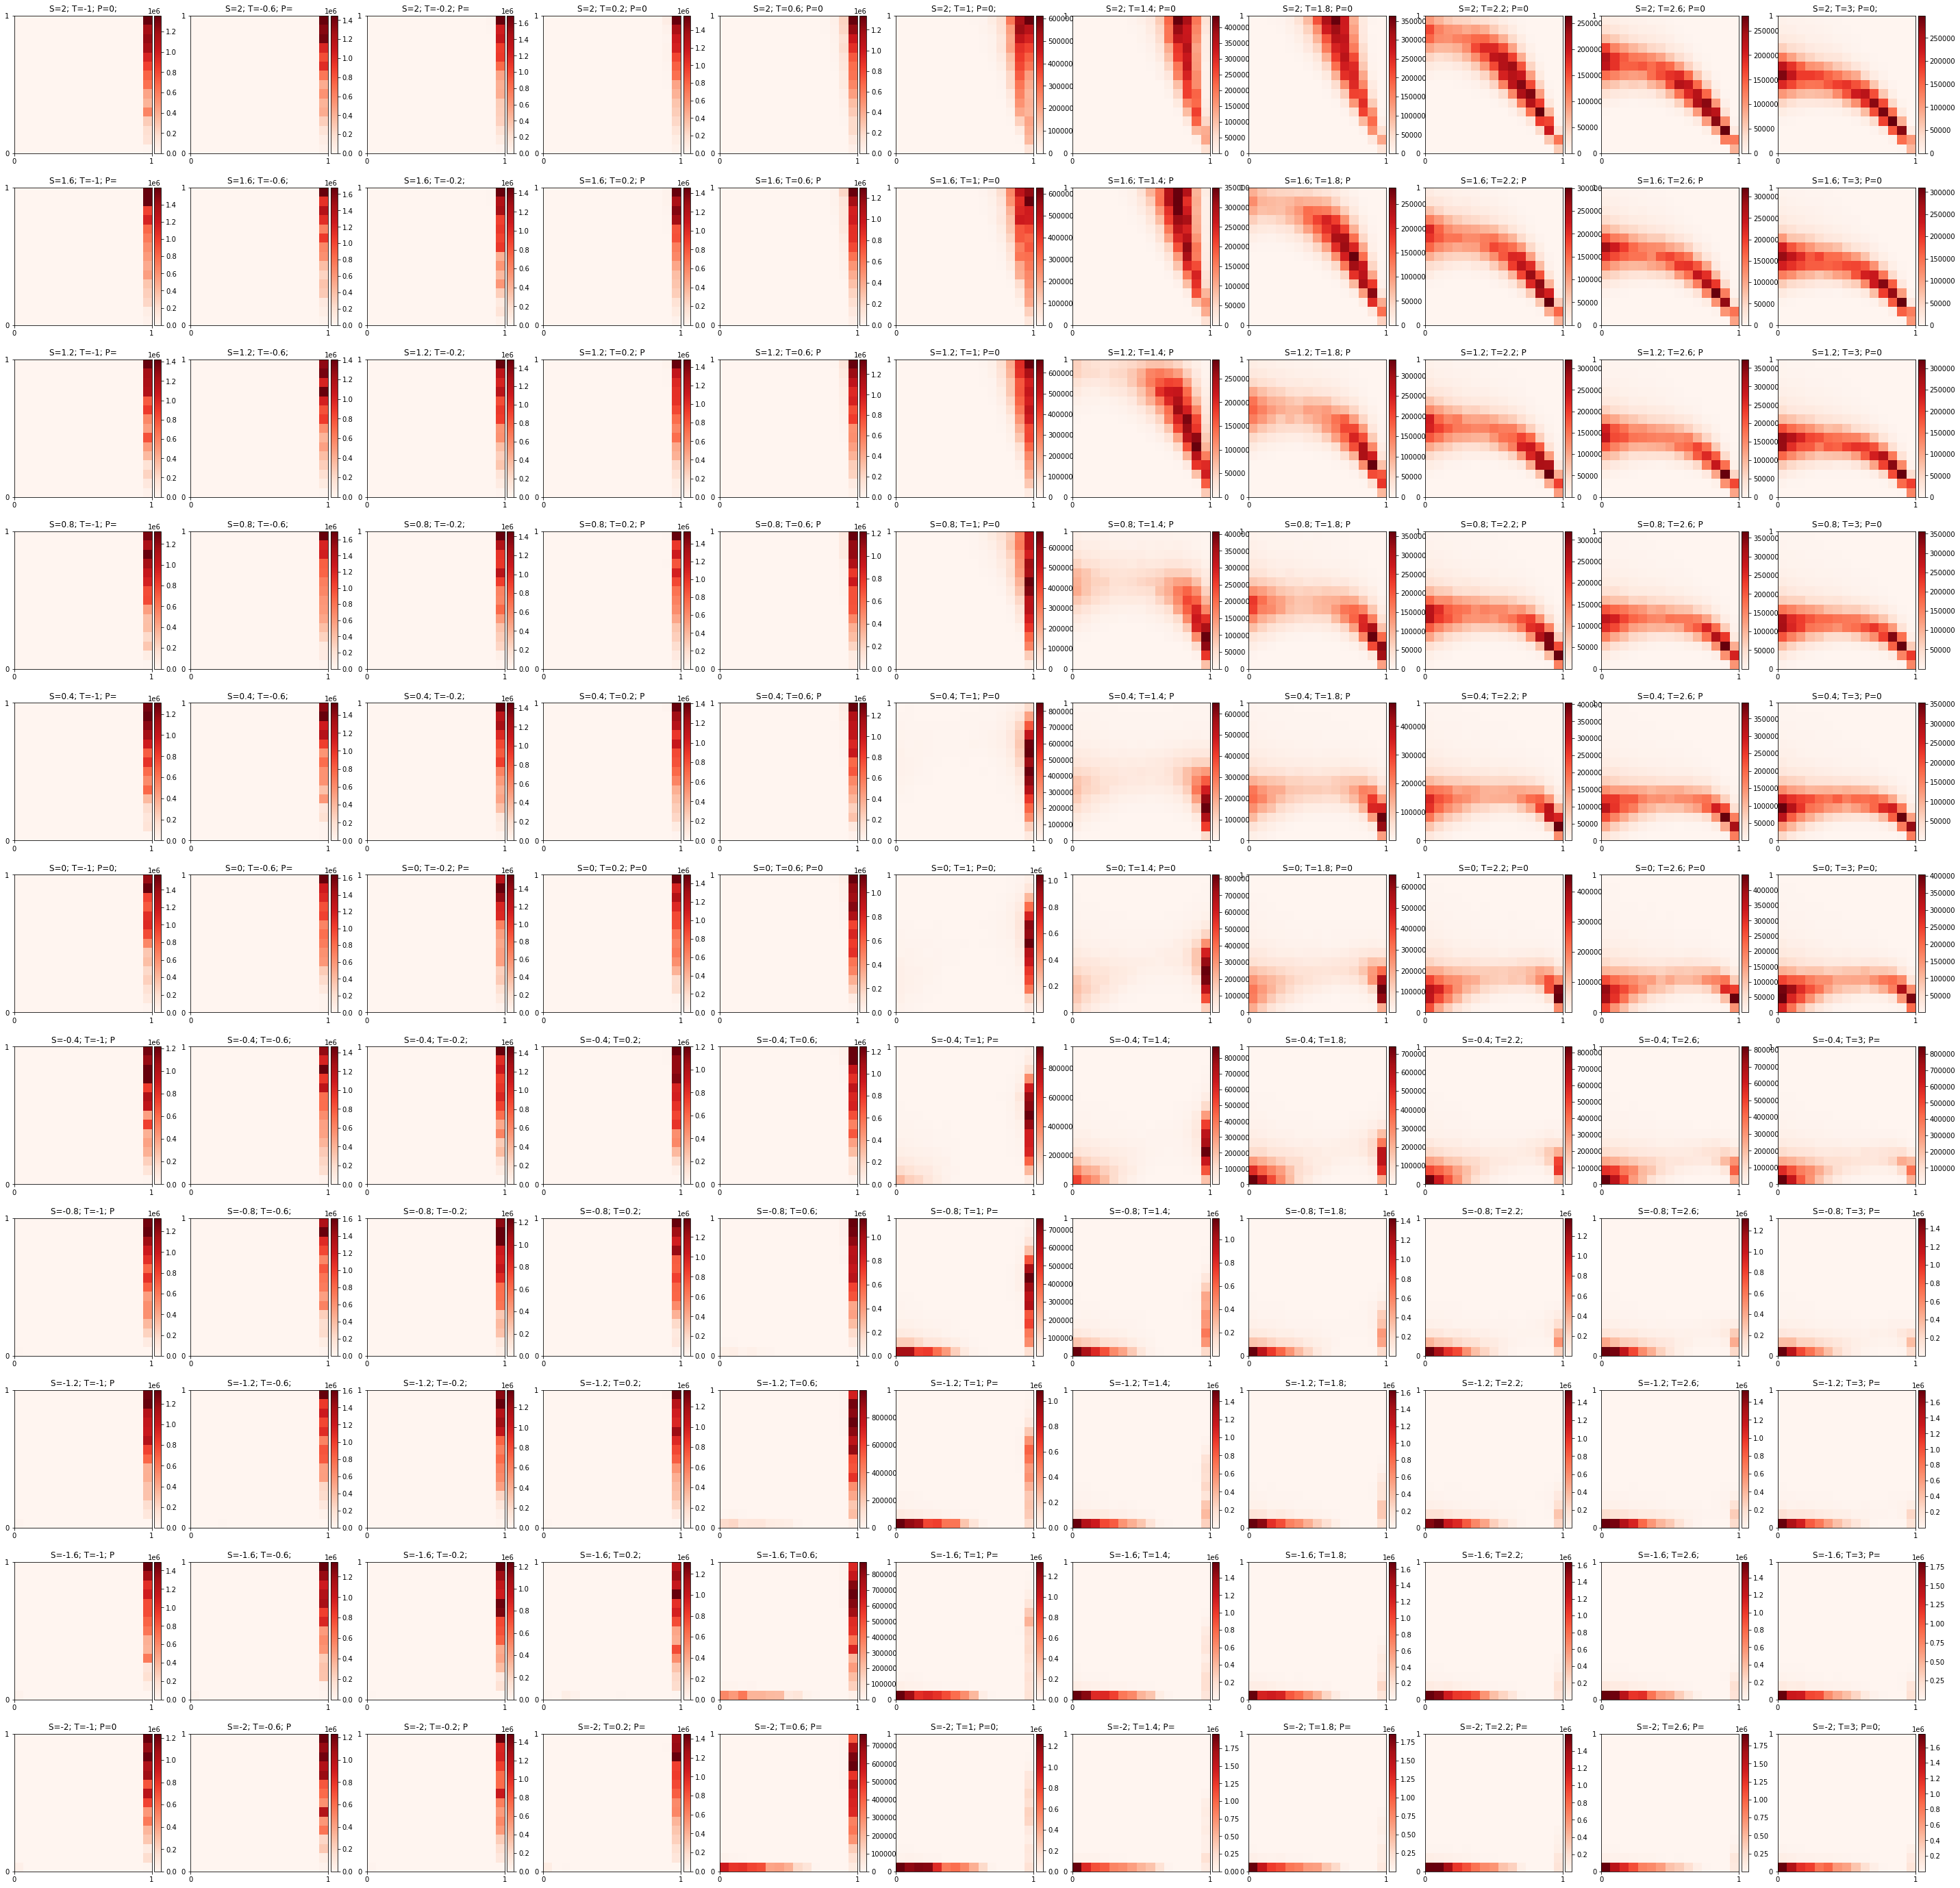

In [156]:
fig, axes = plt.subplots(nrows=11, ncols=11, figsize=(50, 50));

for i, file in enumerate(sorted_cvs_files):
    
    df = dd.read_csv(file,
                 header=None,
                 dtype=np.float64,
                 names=columns)
    
    text_file = open(file.replace("csv", "txt"), "r")
    data = text_file.readlines()
    
    ps = df['p'].values.compute()
    qs = df['q'].values.compute()
    title = data[0][5:20]
    
    index = (int(i / 11), i % 11)
    
    heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=15)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axes[index].imshow(heatmap.T, extent=extent, cmap=cmaps[1], origin="lower")

    divider = make_axes_locatable(axes[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axes[index].set_title(title)

    axes[index].set_xticks(np.linspace(0, 1, 2))
    axes[index].set_yticks(np.linspace(0, 1, 2))
    
fig.savefig("matlab/images/merged_plot_stochastic.pdf")

In [157]:
cooperation_rates_stoch = np.zeros((11, 11))
scores_stoch = np.zeros((11, 11))

In [158]:
for i, file in enumerate(sorted_cvs_files):
    x = int(i / 11)
    y = i % 11
    
    df = dd.read_csv(file,
             header=None,
             dtype=np.float64,
             names=columns)
    
    cooperation_rates_stoch[x, y] = df['average cooperation rate'].mean().compute()
    scores_stoch[x, y] = df['average score'].mean().compute()

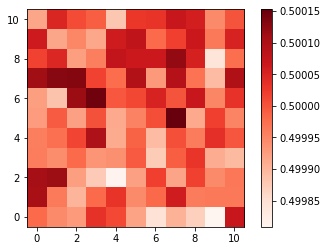

In [159]:
plt.imshow(cooperation_rates_stoch, origin="lower", cmap=cmaps[1])

plt.colorbar();

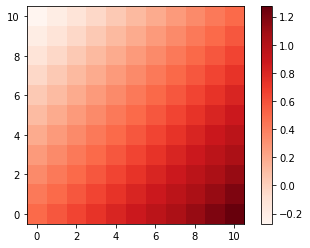

In [160]:
plt.imshow(scores_stoch, origin="lower", cmap=cmaps[1])

plt.colorbar();